In [2]:
from IPython.core.display import display, HTML
display(HTML("""<style> .container {width:96% !important;}</style>"""))
import warnings
warnings.filterwarnings("ignore")

#### https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
# from plotly.offline import init_notebook_mode, iplot
# import cufflinks as cf
# init_notebook_mode()
# cf.go_offline()
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline

In [4]:
train = pd.read_csv('hp_data/train.csv', index_col=0)
test = pd.read_csv('hp_data/test.csv', index_col=0)

In [5]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print(train.shape, test.shape, [col for col in train.columns if col not in test.columns])

(1460, 80) (1459, 79) ['SalePrice']


In [7]:
# udf
def plot_scatter(x, df = train, y = 'SalePrice', ylim = (0, 800000)):
    return df.plot.scatter(x = x, y = y, ylim = ylim);

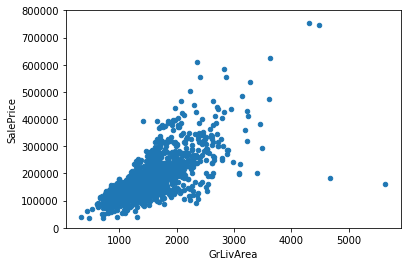

In [8]:
train = pd.read_csv('hp_data/train.csv', index_col=0)
plot_scatter('GrLivArea', train)

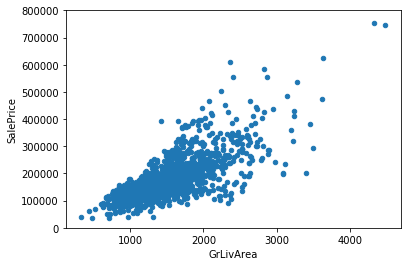

In [9]:
# remove outliners

train = pd.read_csv('hp_data/train.csv', index_col=0)
train = train[~((train['GrLivArea']>4000) & (train['SalePrice']<300000))]
plot_scatter('GrLivArea', train)


 mu = 180932.92 and sigma = 79467.79



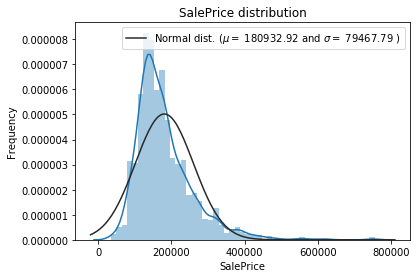

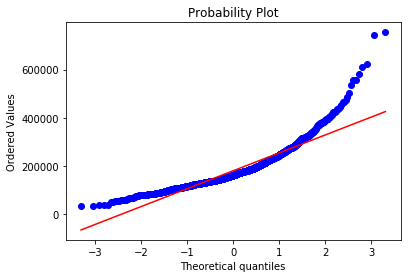

In [10]:
sns.distplot(train['SalePrice'], fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)


 mu = 12.02 and sigma = 0.40



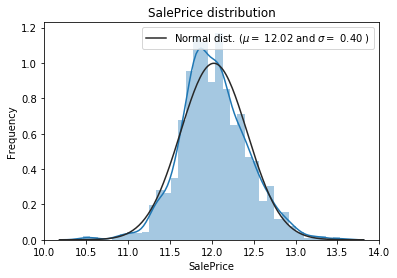

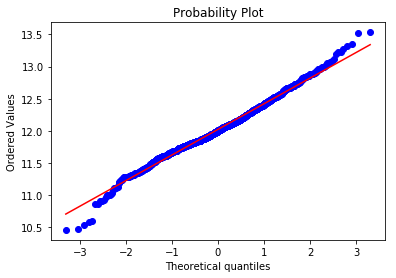

In [11]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [12]:
def plot_dist(var, df, fit = norm):
    sns.distplot(df[var] , fit=fit);
    (mu, sigma) = norm.fit(df[var])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title('%s distribution'%var)
    #QQ-plot
    fig = plt.figure()
    res = stats.probplot(df[var], plot=plt)
    plt.show()
    return

In [13]:
# plot_dist('SalePrice', train)

## Features engineering 1

let's first concatenate the train and test data in the same dataframe

In [14]:
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [15]:
# missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5,1,'Percent missing data by feature')

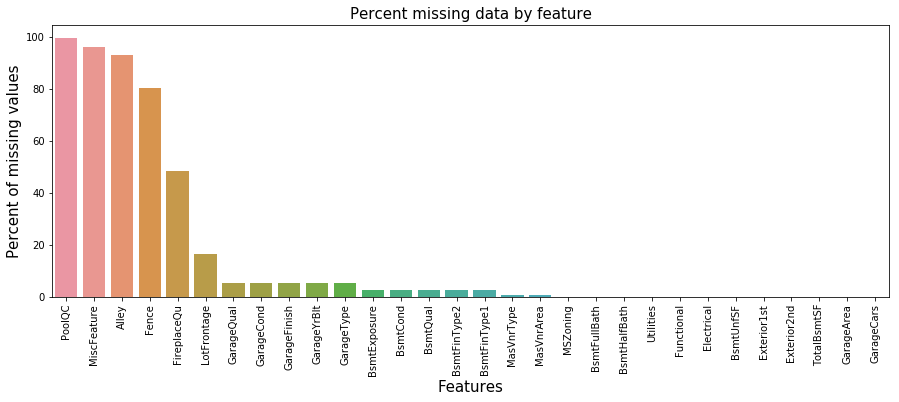

In [16]:
f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

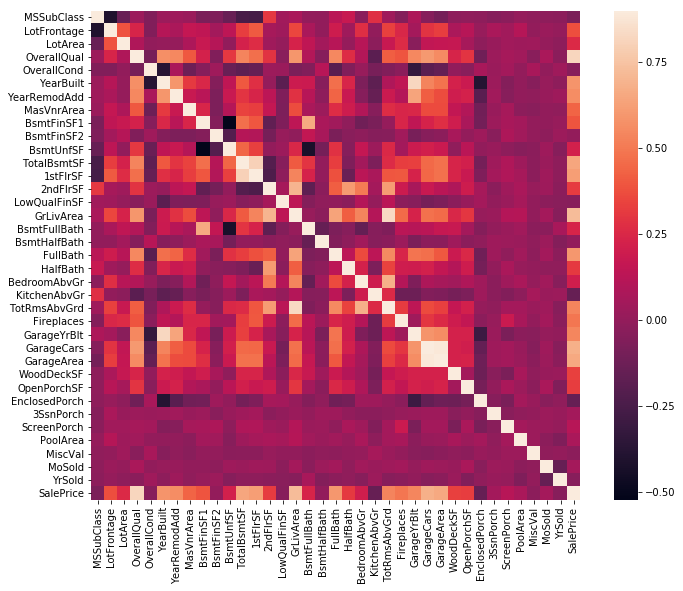

In [17]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## Imputing missing values

In [18]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [19]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [20]:
# check if LotFrontage similar within neighborhood...
pd.DataFrame({'mean' : all_data.groupby('Neighborhood').LotFrontage.mean(),
              'std'  : all_data.groupby('Neighborhood').LotFrontage.std()
             })

,mean,std
Neighborhood,,
Blmngtn,45.785714,4.499853
Blueste,27.300000,5.313505
BrDale,21.500000,1.137147
BrkSide,55.212963,12.027267
ClearCr,83.977273,15.527153
CollgCr,71.101124,14.472721
Crawfor,69.961165,17.162386
Edwards,65.098958,17.429457
Gilbert,70.866667,23.739319


In [21]:
# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [22]:
# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [23]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [24]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [25]:
# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [26]:
# MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
display(all_data['MSZoning'].value_counts())
# all_data['MSZoning'].mode()[0]

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [27]:
# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
display(all_data.Utilities.value_counts())

all_data = all_data.drop(['Utilities'], axis=1)

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [28]:
# Functional: Home functionality (Assume typical unless deductions are warranted)
# Functional : data description says NA means typical

# all_data.Functional.value_counts()

all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [29]:
# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
display(all_data.Electrical.value_counts())

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [30]:
# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
display(all_data.KitchenQual.value_counts())

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

TA    1492
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [31]:
# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
display(all_data.Exterior1st.value_counts().head(),
        all_data.Exterior2nd.value_counts().head())

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])


VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
Name: Exterior1st, dtype: int64

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
Name: Exterior2nd, dtype: int64

In [32]:
# SaleType : Fill in again with most frequent which is "WD"
display(all_data.SaleType.value_counts().head())

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

WD       2525
New       237
COD        87
ConLD      26
CWD        12
Name: SaleType, dtype: int64

In [33]:
# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [34]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## Features engineering 2

#### Transforming some numerical variables that are really categorical

In [35]:
display(all_data['MSSubClass'].value_counts().head(),
        all_data['OverallCond'].value_counts().head(),
        all_data['YrSold'].value_counts().head(),
        all_data['MoSold'].value_counts().head()
       )

20     1079
60      573
50      287
120     182
30      139
Name: MSSubClass, dtype: int64

5    1643
6     531
7     390
8     144
4     101
Name: OverallCond, dtype: int64

2007    691
2009    647
2008    621
2006    619
2010    339
Name: YrSold, dtype: int64

6    503
7    446
5    394
4    279
8    233
Name: MoSold, dtype: int64

In [36]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [37]:
# Label Encoding some categorical variables that may contain information in their ordering set

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [38]:
# Adding total sqfootage feature - Since area related features are very important to determine house prices, 
# we add one more feature which is the total area of basement, first and second floor areas of each house
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed features

In [39]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [40]:
skewness = skewness[abs(skewness) > 0.75]
skewness.shape

(59, 1)

In [41]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


 mu = 13.17 and sigma = 0.96



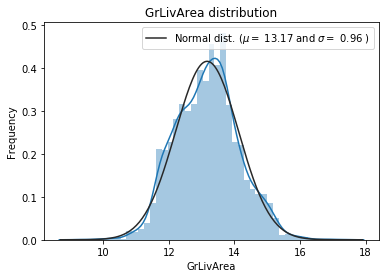

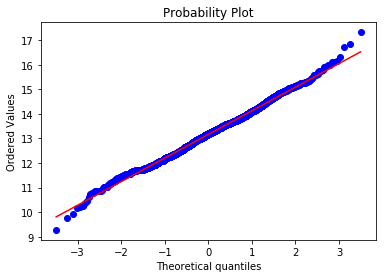

In [42]:
plot_dist('GrLivArea', df = all_data)

In [43]:
print(all_data.shape)
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 79)
(2917, 220)


In [44]:
ntrain = train.shape[0]
ntest = test.shape[0]
ntrain + ntest

2917

In [45]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [46]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

/Users/ehda-calvin/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/ehda-calvin/anaconda/envs/py37/lib/python3.7/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", 

In [47]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base models

In [48]:
# LASSO Regression :
# This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic Net Regression :
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# Kernel Ridge Regression :
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Gradient Boosting Regression :
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# LightGBM :
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [50]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07898668813465672


In [52]:
test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1458,11.818680,0.000000,0.0,0.730463,1.194318,1.820334,1.540963,10.105326,7.397498,2.055642,...,0,0,0,0,0,0,0,0,0,1
1459,12.943735,0.000000,0.0,0.730463,1.540963,1.820334,1.540963,11.901094,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
1460,11.916131,11.151348,0.0,0.730463,1.540963,1.820334,1.540963,11.476685,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
1461,11.910125,11.062536,0.0,0.730463,1.540963,1.820334,1.540963,10.749651,0.000000,1.194318,...,0,0,0,0,0,0,0,0,0,1
1462,12.833625,0.000000,0.0,0.730463,1.194318,1.820334,1.540963,8.720170,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [67]:
# sub[sub.Id > 2900]

check_test = pd.read_csv('hp_data/test.csv')
testID = check_test.Id.tolist()

In [70]:
sub = pd.DataFrame()
sub['Id'] = testID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)

In [71]:
# model_lgb.fit(train, y_train)
# lgb_train_pred = model_lgb.predict(train)
# lgb_pred = np.expm1(model_lgb.predict(test.values))
# print(rmsle(y_train, lgb_train_pred))

In [72]:
sub.tail()

,Id,SalePrice
1454,2915,80383.882812
1455,2916,86726.421875
1456,2917,164529.281250
1457,2918,123241.414062
1458,2919,224239.125000


In [53]:
xgb_train_pred

array([12.228297, 12.08795 , 12.267867, ..., 12.485106, 11.850014,
       11.926238], dtype=float32)

In [48]:
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [74]:
who

BaseEstimator	 BayesianRidge	 ENet	 ElasticNet	 GBoost	 GradientBoostingRegressor	 HTML	 KFold	 KRR	 
KernelRidge	 LabelEncoder	 Lasso	 LassoLarsIC	 RandomForestRegressor	 RegressorMixin	 RobustScaler	 TransformerMixin	 all_data	 
all_data_na	 ax	 boxcox1p	 c	 check_test	 clone	 col	 cols	 corrmat	 
cross_val_score	 display	 f	 feat	 fig	 lam	 lasso	 lbl	 lgb	 
make_pipeline	 mean_squared_error	 missing_data	 model_lgb	 model_xgb	 mu	 n_folds	 norm	 np	 
ntest	 ntrain	 numeric_feats	 pd	 plot_dist	 plot_scatter	 plt	 res	 rmsle	 
rmsle_cv	 sigma	 skew	 skewed_feats	 skewed_features	 skewness	 sns	 stats	 sub	 
test	 testID	 train	 train_test_split	 warnings	 xgb	 xgb_pred	 xgb_train_pred	 y_train	 



In [75]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])